# io_uring io_depth Time-Series Analysis

This notebook visualizes io_uring submit batch size (io_depth) over time during BenchFS benchmark runs.

## Data Source
- `io_depth_raw.csv`: Raw per-submit io_depth data
- `io_depth_aggregated.csv`: Aggregated by time interval and node (optional)

## Key Metrics
- **io_depth**: Number of SQEs in the submission queue at submit time
- **sqe_count**: Number of SQEs submitted in this batch
- Lower io_depth indicates suboptimal io_uring batching

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configure plot sizes
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

In [5]:
# Load the raw CSV
# Update this path to your results directory
RESULTS_DIR = Path('/work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.01.23-13.09.00-debug_large/2026.01.23-13.09.38-540268.nqsv-16')

csv_path = RESULTS_DIR / 'io_depth_raw.csv'
if not csv_path.exists():
    print(f"CSV not found at {csv_path}")
    print("Please run extract_io_depth_csv.sh first:")
    print(f"  ./jobs/benchfs/extract_io_depth_csv.sh {RESULTS_DIR} --aggregate 1")
else:
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    df.head()

Loaded 1457377 records
Columns: ['timestamp', 'node', 'sqe_count', 'io_depth']


In [6]:
# Parse timestamps and add relative time
def parse_timestamp(ts_str):
    """Parse ISO timestamp string to datetime."""
    try:
        # Remove 'Z' suffix and parse
        ts_str = ts_str.replace('Z', '+00:00')
        return datetime.fromisoformat(ts_str)
    except:
        return None

df['datetime'] = df['timestamp'].apply(parse_timestamp)
df = df.dropna(subset=['datetime'])

# Calculate relative time in seconds from start
start_time = df['datetime'].min()
df['time_relative'] = (df['datetime'] - start_time).dt.total_seconds()

# Basic statistics
print(f"Time range: {df['datetime'].min()} - {df['datetime'].max()}")
print(f"Duration: {df['time_relative'].max():.1f} seconds")
print(f"Nodes: {sorted(df['node'].unique())}")
print(f"\nio_depth statistics:")
print(f"  Min: {df['io_depth'].min()}")
print(f"  Max: {df['io_depth'].max()}")
print(f"  Mean: {df['io_depth'].mean():.2f}")
print(f"  Median: {df['io_depth'].median():.2f}")

Time range: 2026-01-23 04:12:18.338596+00:00 - 2026-01-23 04:19:42.382278+00:00
Duration: 444.0 seconds
Nodes: ['0[bnode036', '0[bnode038', '0[bnode039', '0[bnode066', '0[bnode067', '2[bnode036', '2[bnode038', '2[bnode062', '2[bnode063', '3[bnode066', '[bnode034', '[bnode036', '[bnode038', '[bnode039', '[bnode062', '[bnode063', '[bnode066', '[bnode067', '[bnode068', '[bnode071', 'b[bnode031', 'b[bnode034', 'b[bnode039', 'b[bnode062', 'b[bnode064', 'b[bnode068', 'b[bnode071', 'bn[bnode031', 'bn[bnode034', 'bn[bnode036', 'bn[bnode038', 'bn[bnode058', 'bn[bnode062', 'bn[bnode066', 'bn[bnode067', 'bn[bnode068', 'bn[bnode069', 'bn[bnode071', 'bno[bnode036', 'bno[bnode038', 'bno[bnode058', 'bno[bnode062', 'bno[bnode063', 'bno[bnode064', 'bno[bnode065', 'bno[bnode066', 'bno[bnode067', 'bno[bnode068', 'bno[bnode069', 'bnod[bnode038', 'bnod[bnode039', 'bnod[bnode062', 'bnod[bnode065', 'bnod[bnode066', 'bnod[bnode067', 'bnod[bnode069', 'bnod[bnode071', 'bnode029', 'bnode029[bnode034', 'bnode029[

## 1. io_depth Distribution Overview

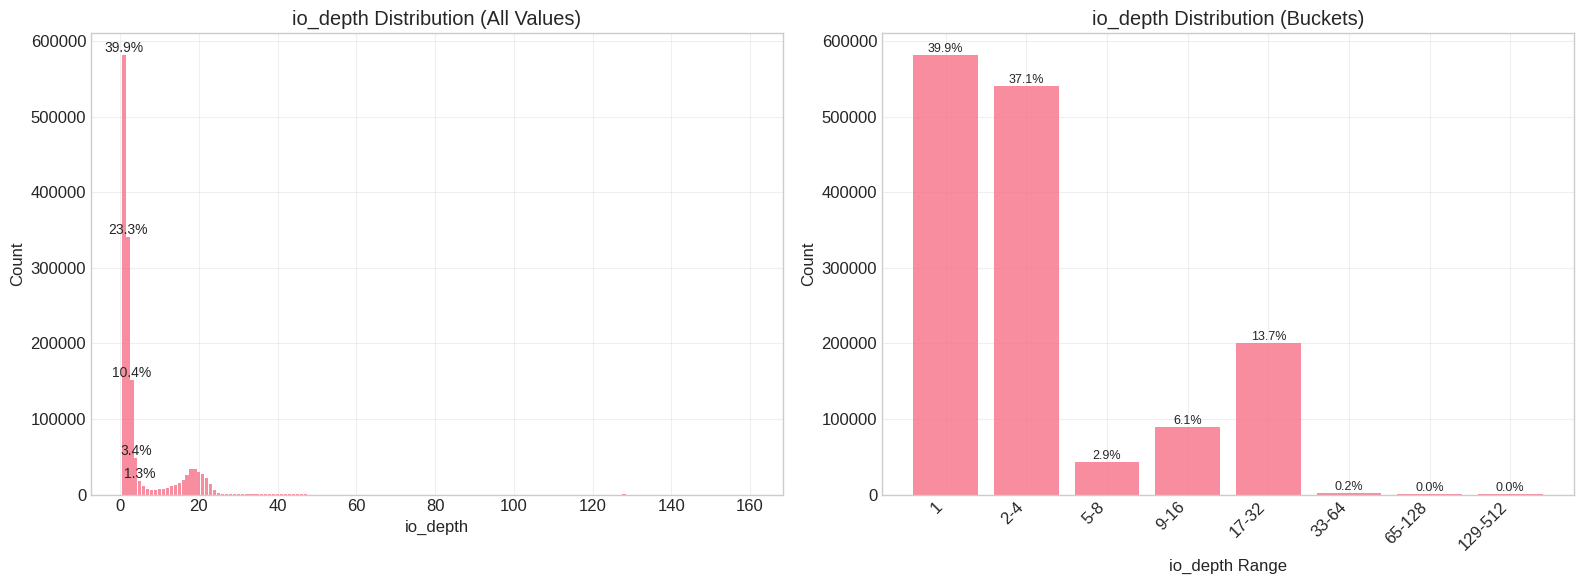

In [7]:
# io_depth distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Full distribution
ax = axes[0]
depth_counts = df['io_depth'].value_counts().sort_index()
ax.bar(depth_counts.index, depth_counts.values, alpha=0.8)
ax.set_xlabel('io_depth')
ax.set_ylabel('Count')
ax.set_title('io_depth Distribution (All Values)')
ax.grid(True, alpha=0.3)

# Add percentage labels for top values
total = len(df)
for depth in depth_counts.head(5).index:
    count = depth_counts[depth]
    pct = count / total * 100
    ax.annotate(f'{pct:.1f}%', xy=(depth, count), ha='center', va='bottom', fontsize=10)

# Right: Log-scale buckets
ax = axes[1]
buckets = [(1, 1), (2, 4), (5, 8), (9, 16), (17, 32), (33, 64), (65, 128), (129, 512)]
bucket_labels = ['1', '2-4', '5-8', '9-16', '17-32', '33-64', '65-128', '129-512']
bucket_counts = []
for lo, hi in buckets:
    count = len(df[(df['io_depth'] >= lo) & (df['io_depth'] <= hi)])
    bucket_counts.append(count)

bars = ax.bar(range(len(bucket_labels)), bucket_counts, alpha=0.8)
ax.set_xticks(range(len(bucket_labels)))
ax.set_xticklabels(bucket_labels, rotation=45, ha='right')
ax.set_xlabel('io_depth Range')
ax.set_ylabel('Count')
ax.set_title('io_depth Distribution (Buckets)')
ax.grid(True, alpha=0.3)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, bucket_counts)):
    pct = count / total * 100
    ax.annotate(f'{pct:.1f}%', xy=(i, count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_depth_distribution.png', dpi=150)
plt.show()

# Print warning if mostly io_depth=1
depth_1_pct = len(df[df['io_depth'] == 1]) / total * 100
if depth_1_pct > 50:
    print(f"\n*** WARNING: {depth_1_pct:.1f}% of submits have io_depth=1 ***")
    print("io_uring batching is highly inefficient!")

## 2. io_depth Over Time

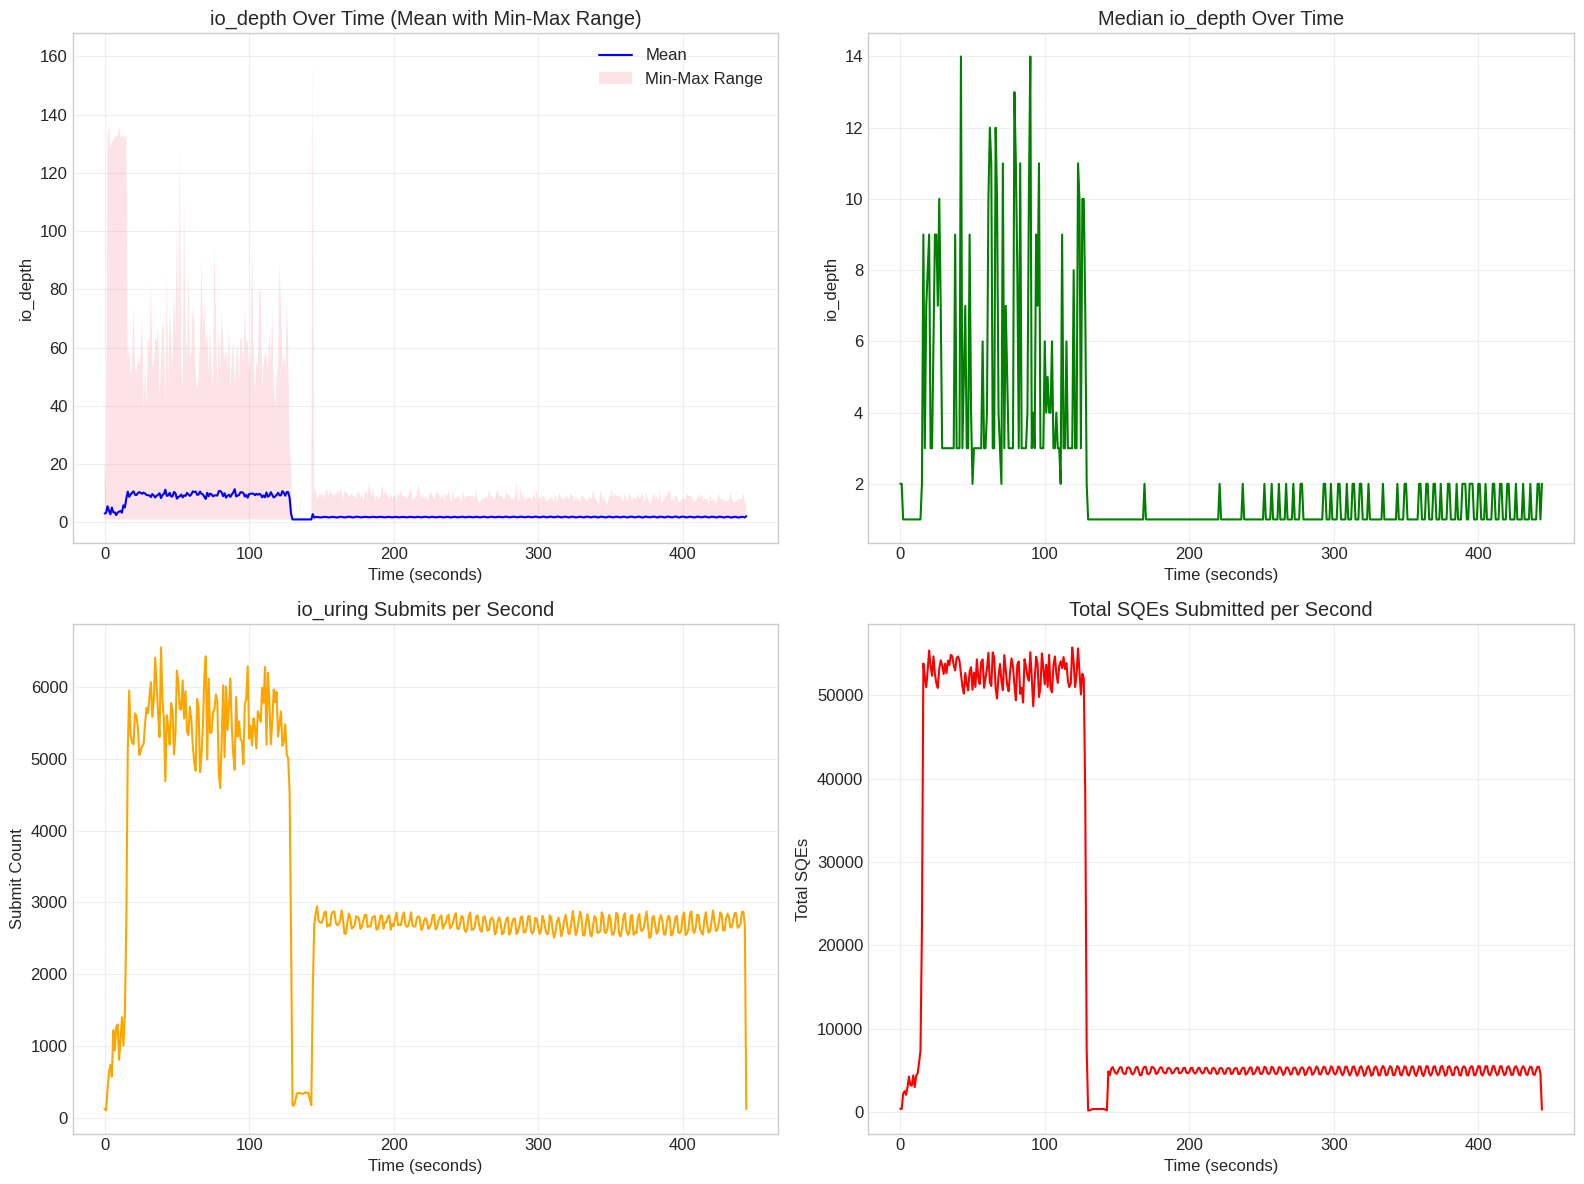

In [8]:
# Aggregate io_depth by time bucket (1 second)
time_bucket = 1  # seconds
df['time_bucket'] = (df['time_relative'] // time_bucket).astype(int) * time_bucket

# Calculate statistics per time bucket
time_stats = df.groupby('time_bucket').agg({
    'io_depth': ['mean', 'median', 'min', 'max', 'std', 'count'],
    'sqe_count': 'sum'
}).reset_index()
time_stats.columns = ['time', 'mean', 'median', 'min', 'max', 'std', 'submit_count', 'total_sqes']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mean io_depth over time
ax = axes[0, 0]
ax.plot(time_stats['time'], time_stats['mean'], linewidth=1.5, label='Mean', color='blue')
ax.fill_between(time_stats['time'], time_stats['min'], time_stats['max'], alpha=0.2, label='Min-Max Range')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('io_depth')
ax.set_title('io_depth Over Time (Mean with Min-Max Range)')
ax.legend()
ax.grid(True, alpha=0.3)

# Median io_depth over time
ax = axes[0, 1]
ax.plot(time_stats['time'], time_stats['median'], linewidth=1.5, color='green')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('io_depth')
ax.set_title('Median io_depth Over Time')
ax.grid(True, alpha=0.3)

# Submit count per second
ax = axes[1, 0]
ax.plot(time_stats['time'], time_stats['submit_count'], linewidth=1.5, color='orange')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Submit Count')
ax.set_title('io_uring Submits per Second')
ax.grid(True, alpha=0.3)

# Total SQEs per second
ax = axes[1, 1]
ax.plot(time_stats['time'], time_stats['total_sqes'], linewidth=1.5, color='red')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Total SQEs')
ax.set_title('Total SQEs Submitted per Second')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_depth_over_time.png', dpi=150)
plt.show()

## 3. Per-Node io_depth Analysis

Per-Node io_depth Statistics:
             node      mean  median  min  max       std  submit_count  total_sqes
       0[bnode036  2.000000     2.0    2    2       NaN             1           2
       0[bnode038 14.000000    14.0   14   14       NaN             1          14
       0[bnode039  3.000000     3.0    3    3       NaN             1           3
       0[bnode066  7.000000     7.0    7    7       NaN             1           7
       0[bnode067  6.000000     6.0    6    6       NaN             1           6
       2[bnode036  2.000000     2.0    2    2       NaN             1           2
       2[bnode038 19.000000    19.0   19   19       NaN             1          19
       2[bnode062  2.000000     2.0    2    2       NaN             1           2
       2[bnode063 14.000000    14.0   14   14       NaN             1          14
       3[bnode066 22.000000    22.0   22   22       NaN             1          22
        [bnode034 20.000000    20.0   20   20       NaN             

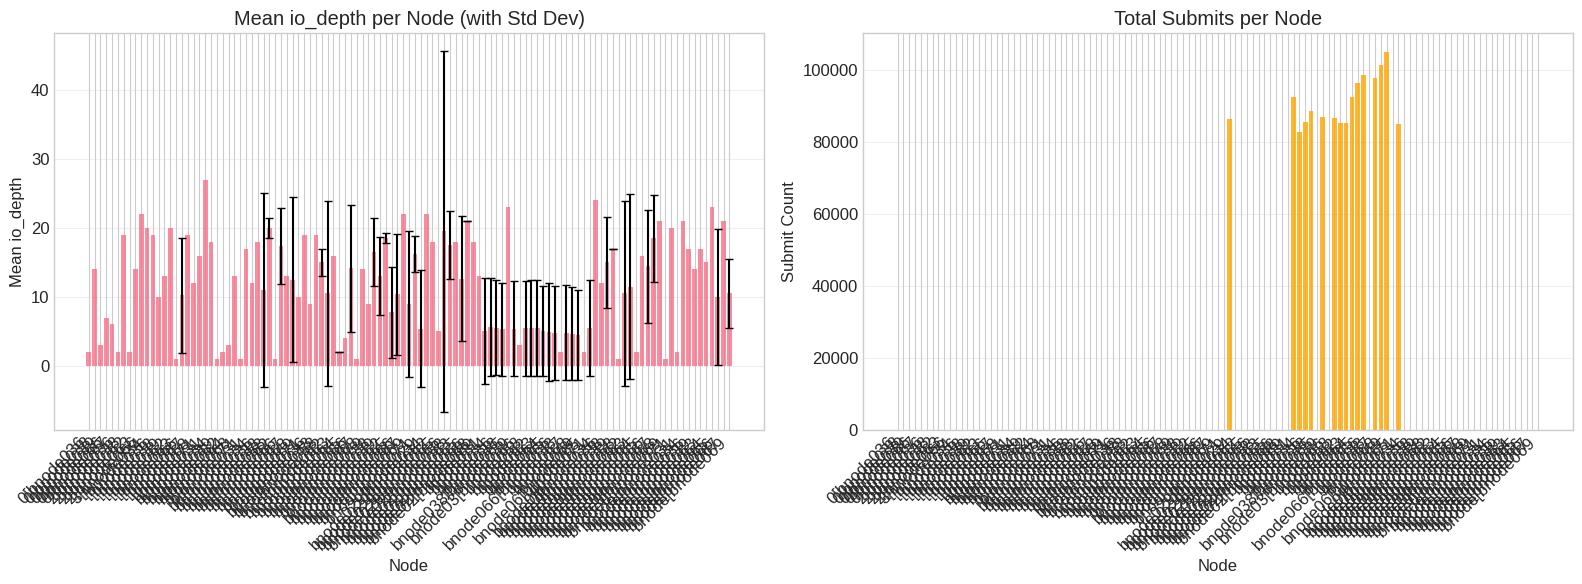

In [9]:
# Per-node io_depth statistics
node_stats = df.groupby('node').agg({
    'io_depth': ['mean', 'median', 'min', 'max', 'std', 'count'],
    'sqe_count': 'sum'
}).reset_index()
node_stats.columns = ['node', 'mean', 'median', 'min', 'max', 'std', 'submit_count', 'total_sqes']
node_stats = node_stats.sort_values('node')

print("Per-Node io_depth Statistics:")
print(node_stats.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean io_depth per node
ax = axes[0]
x = range(len(node_stats))
ax.bar(x, node_stats['mean'], alpha=0.8)
ax.errorbar(x, node_stats['mean'], yerr=node_stats['std'], fmt='none', color='black', capsize=3)
ax.set_xticks(x)
ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
ax.set_xlabel('Node')
ax.set_ylabel('Mean io_depth')
ax.set_title('Mean io_depth per Node (with Std Dev)')
ax.grid(True, alpha=0.3, axis='y')

# Submit count per node
ax = axes[1]
ax.bar(x, node_stats['submit_count'], alpha=0.8, color='orange')
ax.set_xticks(x)
ax.set_xticklabels(node_stats['node'], rotation=45, ha='right')
ax.set_xlabel('Node')
ax.set_ylabel('Submit Count')
ax.set_title('Total Submits per Node')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_depth_per_node.png', dpi=150)
plt.show()

/work/NBB/rmaeda/tmp/ipykernel_2535436/401106549.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


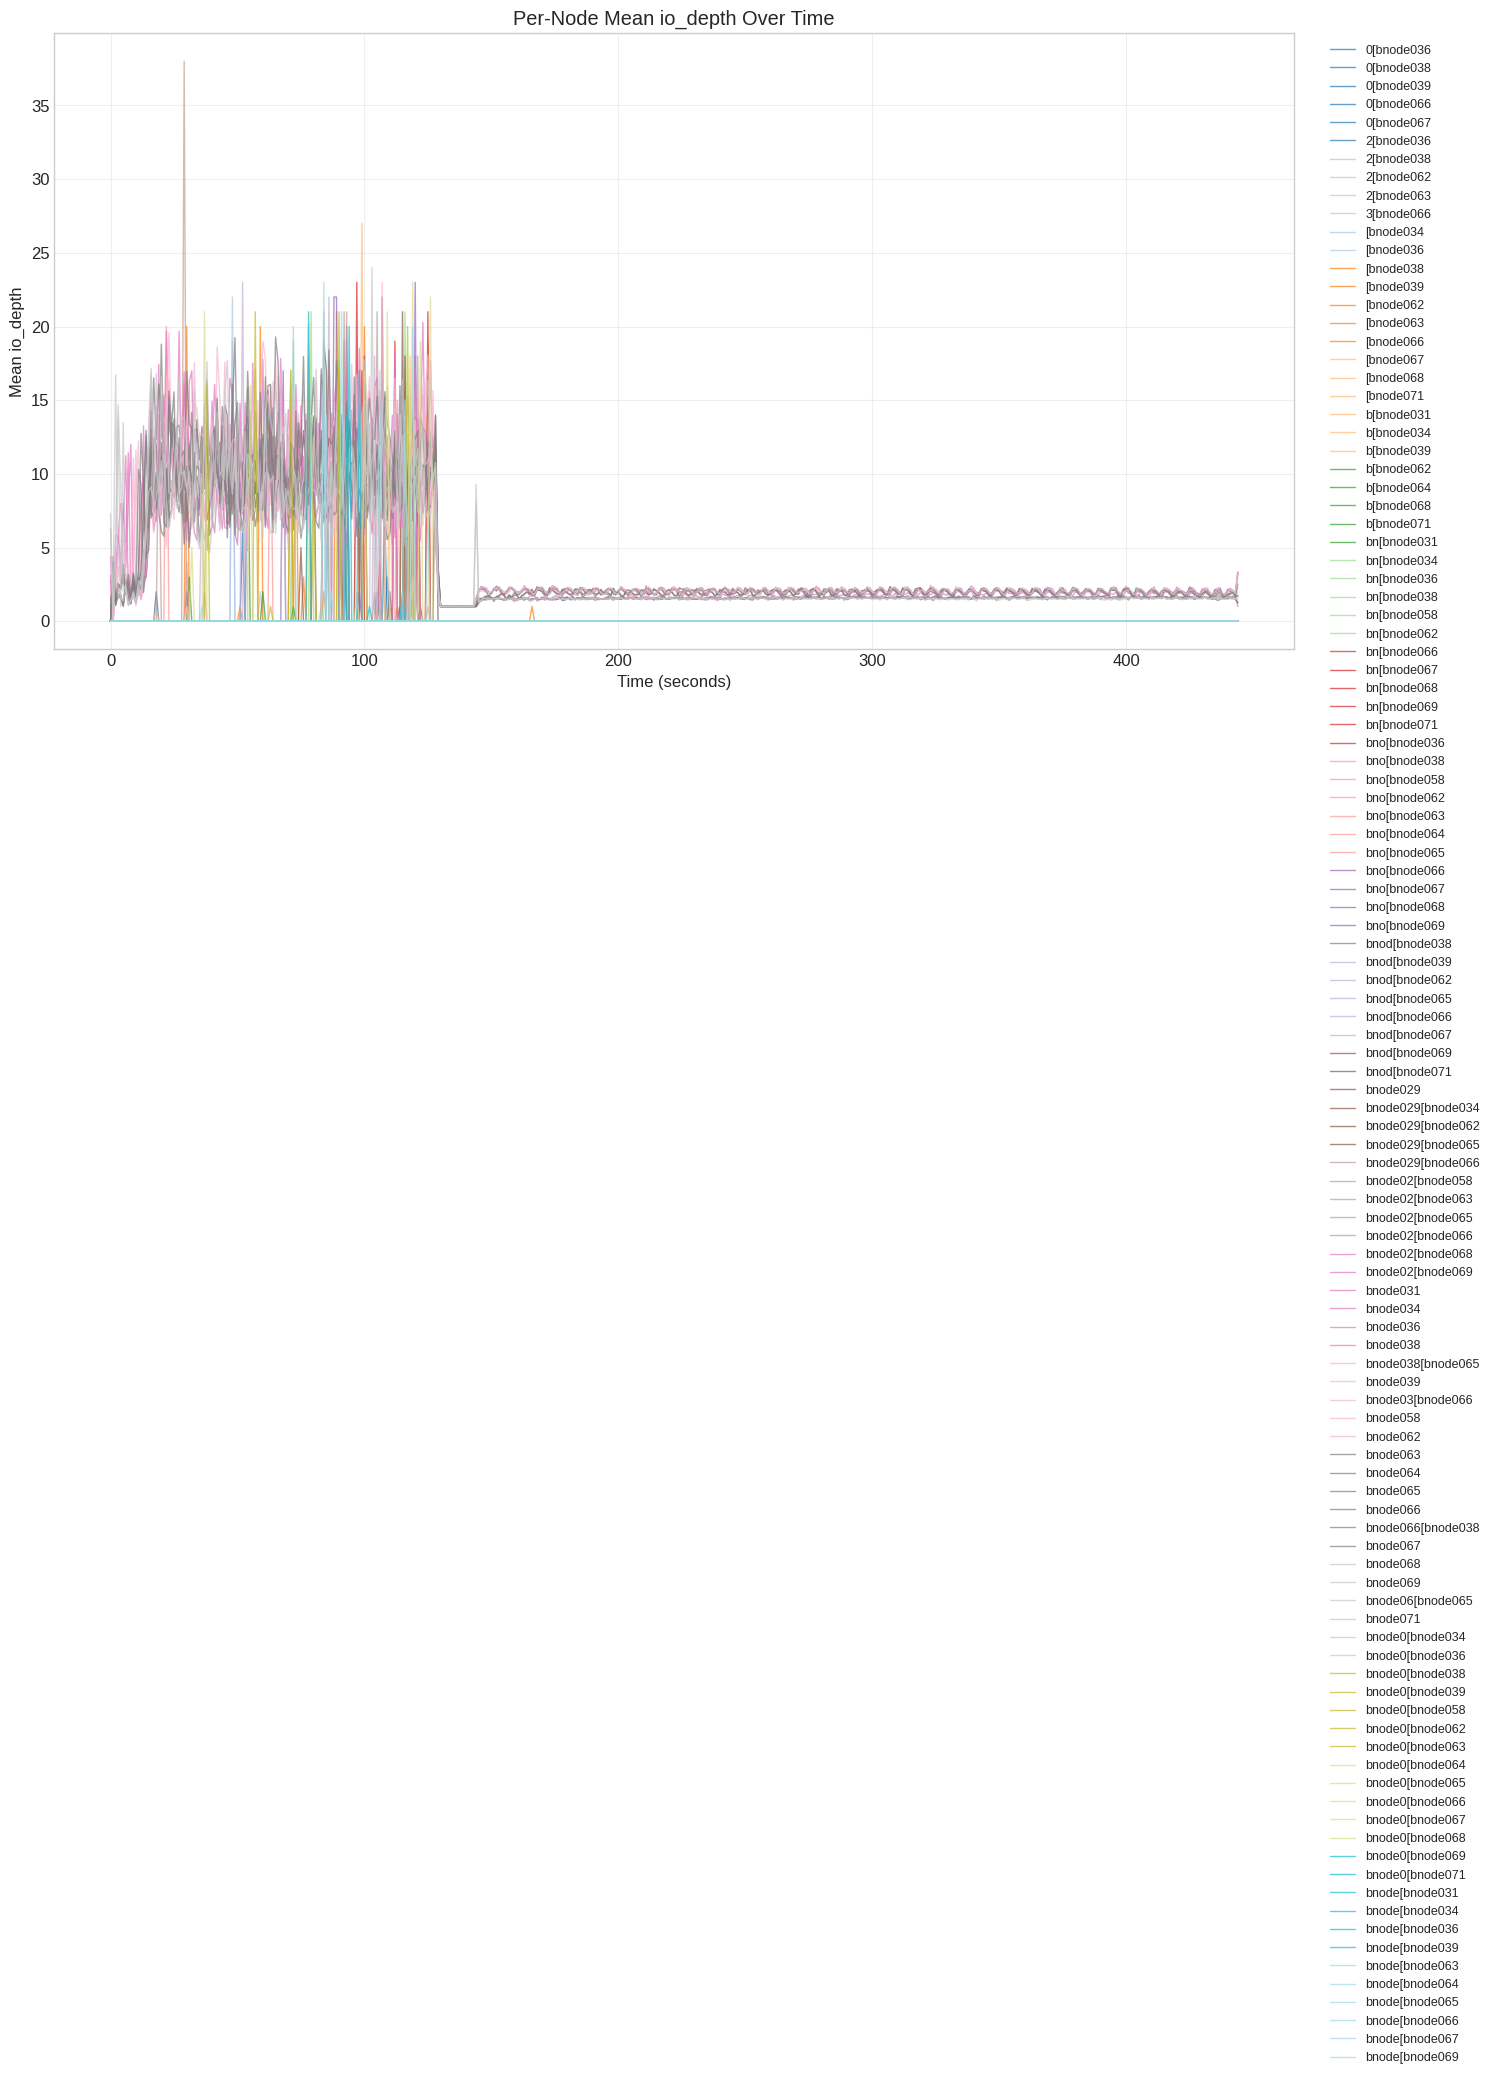

In [10]:
# Per-node io_depth over time
node_time_stats = df.groupby(['time_bucket', 'node']).agg({
    'io_depth': 'mean'
}).reset_index()
node_time_pivot = node_time_stats.pivot(index='time_bucket', columns='node', values='io_depth').fillna(0)

fig, ax = plt.subplots(figsize=(16, 8))

nodes = sorted(node_time_pivot.columns)
colors = plt.cm.tab20(np.linspace(0, 1, len(nodes)))

for i, node in enumerate(nodes):
    if node in node_time_pivot.columns:
        ax.plot(node_time_pivot.index, node_time_pivot[node], 
                label=node, linewidth=1, alpha=0.7, color=colors[i])

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Mean io_depth')
ax.set_title('Per-Node Mean io_depth Over Time')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_depth_per_node_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. io_depth Heatmap

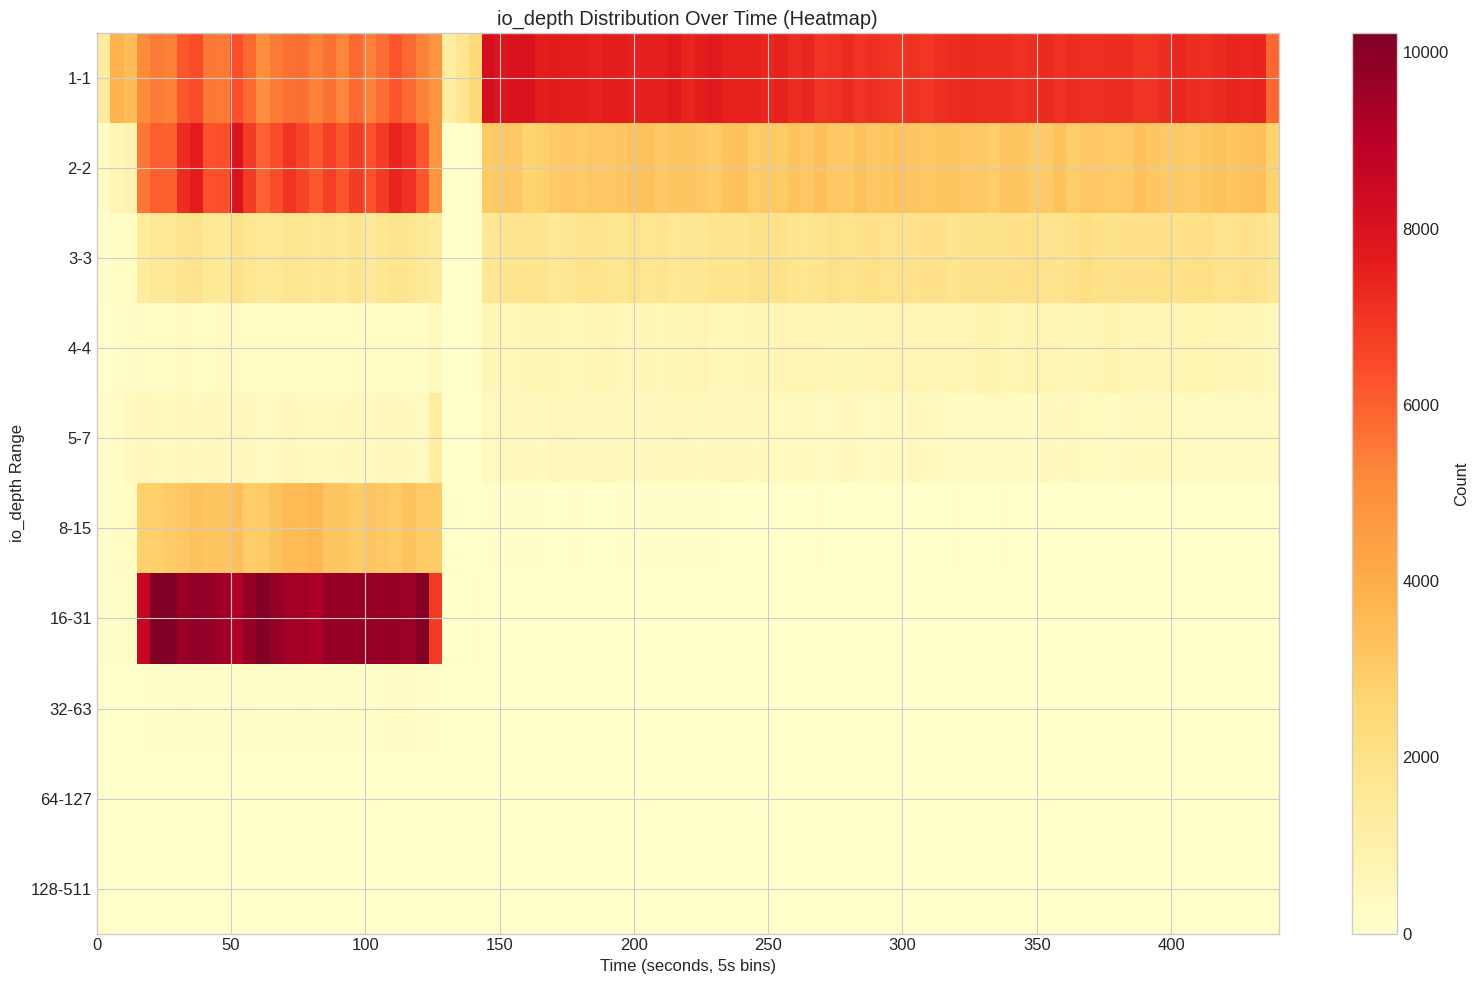

In [11]:
# Heatmap: io_depth distribution over time
time_bin = 5  # seconds
df['time_bin'] = (df['time_relative'] // time_bin).astype(int) * time_bin

# Create histogram per time bin
depth_bins = [1, 2, 3, 4, 5, 8, 16, 32, 64, 128, 512]
heatmap_data = []

for time_bin_val in sorted(df['time_bin'].unique()):
    bin_df = df[df['time_bin'] == time_bin_val]
    row = {'time': time_bin_val}
    for i in range(len(depth_bins) - 1):
        lo, hi = depth_bins[i], depth_bins[i+1] - 1
        count = len(bin_df[(bin_df['io_depth'] >= lo) & (bin_df['io_depth'] <= hi)])
        row[f'{lo}-{hi}'] = count
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data).set_index('time')

fig, ax = plt.subplots(figsize=(16, 10))

im = ax.imshow(heatmap_df.T, aspect='auto', cmap='YlOrRd',
               extent=[heatmap_df.index.min(), heatmap_df.index.max(), 
                       len(heatmap_df.columns)-0.5, -0.5])

ax.set_xlabel(f'Time (seconds, {time_bin}s bins)')
ax.set_ylabel('io_depth Range')
ax.set_title('io_depth Distribution Over Time (Heatmap)')
ax.set_yticks(range(len(heatmap_df.columns)))
ax.set_yticklabels(heatmap_df.columns)

cbar = plt.colorbar(im, ax=ax, label='Count')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_depth_heatmap.png', dpi=150)
plt.show()

## 5. Batching Efficiency Analysis

In [12]:
# Analyze batching efficiency
print("=" * 80)
print("Batching Efficiency Analysis")
print("=" * 80)

total_submits = len(df)
total_sqes = df['sqe_count'].sum()
avg_batch_size = df['io_depth'].mean()

print(f"\nOverall Statistics:")
print(f"  Total io_uring submits: {total_submits:,}")
print(f"  Total SQEs submitted: {total_sqes:,}")
print(f"  Average batch size (io_depth): {avg_batch_size:.2f}")

# Efficiency metrics
depth_1_count = len(df[df['io_depth'] == 1])
depth_1_pct = depth_1_count / total_submits * 100

depth_le4_count = len(df[df['io_depth'] <= 4])
depth_le4_pct = depth_le4_count / total_submits * 100

depth_gt16_count = len(df[df['io_depth'] > 16])
depth_gt16_pct = depth_gt16_count / total_submits * 100

print(f"\nBatching Efficiency:")
print(f"  io_depth=1 (unbatched): {depth_1_count:,} ({depth_1_pct:.1f}%)")
print(f"  io_depth<=4 (low batch): {depth_le4_count:,} ({depth_le4_pct:.1f}%)")
print(f"  io_depth>16 (good batch): {depth_gt16_count:,} ({depth_gt16_pct:.1f}%)")

# Theoretical efficiency
# If every SQE was batched optimally, we'd have fewer submits
ideal_batch_size = 64  # typical good io_uring batch size
ideal_submits = total_sqes / ideal_batch_size
efficiency = ideal_submits / total_submits * 100

print(f"\nTheoretical Efficiency (assuming ideal batch_size={ideal_batch_size}):")
print(f"  Actual submits: {total_submits:,}")
print(f"  Ideal submits: {ideal_submits:,.0f}")
print(f"  Efficiency: {efficiency:.1f}%")

# Performance impact
syscall_overhead_us = 0.5  # typical io_uring_enter syscall overhead
wasted_time_ms = (total_submits - ideal_submits) * syscall_overhead_us / 1000

print(f"\nEstimated Performance Impact:")
print(f"  Extra syscalls: {total_submits - ideal_submits:,.0f}")
print(f"  Wasted time (at {syscall_overhead_us}us/syscall): {wasted_time_ms:.1f} ms")

if depth_1_pct > 50:
    print("\n" + "*" * 80)
    print("*** CRITICAL: Batching is highly inefficient! ***")
    print("*** Most operations are submitted individually (io_depth=1) ***")
    print("*** This is likely caused by synchronous operations blocking io_uring ***")
    print("*" * 80)

Batching Efficiency Analysis

Overall Statistics:
  Total io_uring submits: 1,457,377
  Total SQEs submitted: 7,505,787
  Average batch size (io_depth): 5.15

Batching Efficiency:
  io_depth=1 (unbatched): 581,427 (39.9%)
  io_depth<=4 (low batch): 1,122,479 (77.0%)
  io_depth>16 (good batch): 203,165 (13.9%)

Theoretical Efficiency (assuming ideal batch_size=64):
  Actual submits: 1,457,377
  Ideal submits: 117,278
  Efficiency: 8.0%

Estimated Performance Impact:
  Extra syscalls: 1,340,099
  Wasted time (at 0.5us/syscall): 670.0 ms


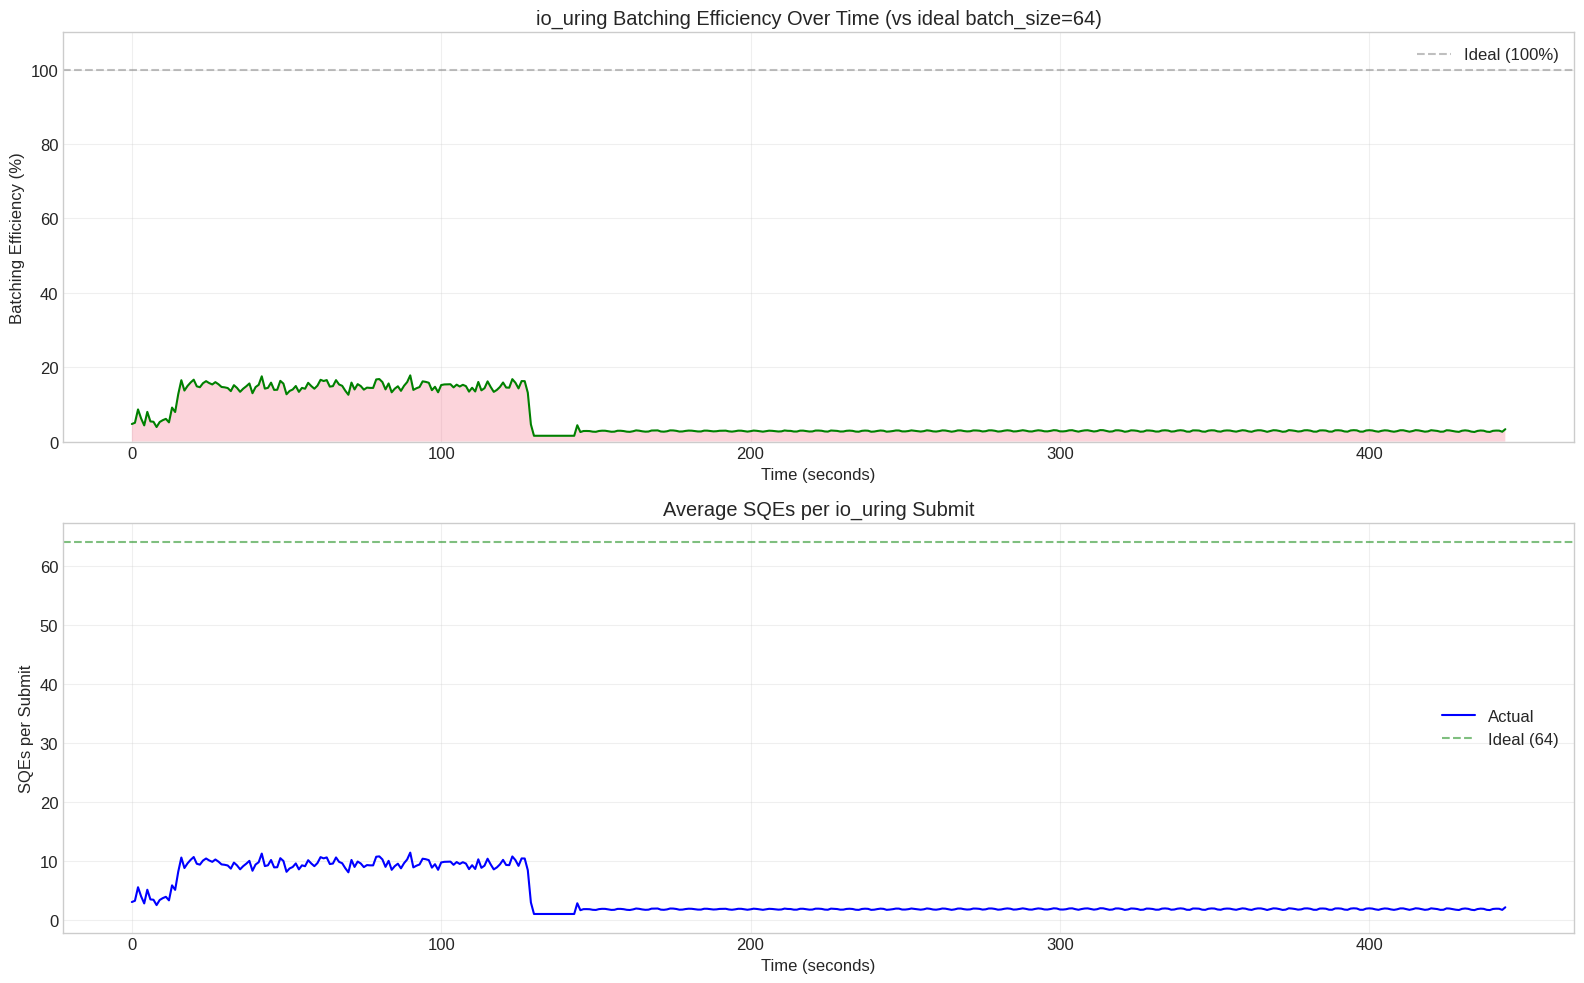

In [13]:
# Efficiency over time
time_efficiency = df.groupby('time_bucket').agg({
    'io_depth': 'mean',
    'sqe_count': ['sum', 'count']
}).reset_index()
time_efficiency.columns = ['time', 'mean_depth', 'total_sqes', 'submit_count']
time_efficiency['efficiency'] = time_efficiency['mean_depth'] / 64 * 100  # vs ideal
time_efficiency['efficiency'] = time_efficiency['efficiency'].clip(upper=100)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Efficiency over time
ax = axes[0]
ax.plot(time_efficiency['time'], time_efficiency['efficiency'], linewidth=1.5, color='green')
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Ideal (100%)')
ax.fill_between(time_efficiency['time'], 0, time_efficiency['efficiency'], alpha=0.3)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Batching Efficiency (%)')
ax.set_title('io_uring Batching Efficiency Over Time (vs ideal batch_size=64)')
ax.set_ylim(0, 110)
ax.legend()
ax.grid(True, alpha=0.3)

# SQEs per submit (inverse of batching)
ax = axes[1]
ax.plot(time_efficiency['time'], time_efficiency['total_sqes'] / time_efficiency['submit_count'], 
        linewidth=1.5, color='blue', label='Actual')
ax.axhline(y=64, color='green', linestyle='--', alpha=0.5, label='Ideal (64)')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('SQEs per Submit')
ax.set_title('Average SQEs per io_uring Submit')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'io_depth_efficiency.png', dpi=150)
plt.show()

## 6. Summary

In [14]:
# Final summary
print("=" * 80)
print("io_depth Analysis Summary")
print("=" * 80)

print(f"\nSource: {RESULTS_DIR}")
print(f"Total submit events: {len(df):,}")
print(f"Total SQEs: {df['sqe_count'].sum():,}")
print(f"Duration: {df['time_relative'].max():.1f} seconds")

print(f"\nio_depth Statistics:")
print(f"  Mean: {df['io_depth'].mean():.2f}")
print(f"  Median: {df['io_depth'].median():.2f}")
print(f"  Min: {df['io_depth'].min()}")
print(f"  Max: {df['io_depth'].max()}")
print(f"  Std: {df['io_depth'].std():.2f}")

print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    val = df['io_depth'].quantile(p/100)
    print(f"  P{p}: {val:.1f}")

print(f"\nBatching Breakdown:")
for label, (lo, hi) in [('unbatched (=1)', (1, 1)), 
                         ('low (2-4)', (2, 4)), 
                         ('medium (5-16)', (5, 16)),
                         ('good (17-64)', (17, 64)),
                         ('excellent (>64)', (65, 9999))]:
    count = len(df[(df['io_depth'] >= lo) & (df['io_depth'] <= hi)])
    pct = count / len(df) * 100
    print(f"  {label}: {count:,} ({pct:.1f}%)")

print(f"\n" + "=" * 80)
if df['io_depth'].mean() < 4:
    print("DIAGNOSIS: io_uring batching is severely inefficient.")
    print("CAUSE: Likely synchronous operations (file open, fsync) blocking the reactor.")
    print("SOLUTION: Ensure all file operations use async io_uring operations.")
elif df['io_depth'].mean() < 16:
    print("DIAGNOSIS: io_uring batching is suboptimal.")
    print("Consider tuning submit_depth threshold or wait_submit_timeout.")
else:
    print("DIAGNOSIS: io_uring batching appears efficient.")
print("=" * 80)

io_depth Analysis Summary

Source: /work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.01.23-13.09.00-debug_large/2026.01.23-13.09.38-540268.nqsv-16
Total submit events: 1,457,377
Total SQEs: 7,505,787
Duration: 444.0 seconds

io_depth Statistics:
  Mean: 5.15
  Median: 2.00
  Min: 1
  Max: 160
  Std: 7.03

Percentiles:
  P25: 1.0
  P50: 2.0
  P75: 4.0
  P90: 18.0
  P95: 21.0
  P99: 24.0

Batching Breakdown:
  unbatched (=1): 581,427 (39.9%)
  low (2-4): 541,052 (37.1%)
  medium (5-16): 131,733 (9.0%)
  good (17-64): 202,918 (13.9%)
  excellent (>64): 247 (0.0%)

DIAGNOSIS: io_uring batching is suboptimal.
Consider tuning submit_depth threshold or wait_submit_timeout.
